## Accessing gridMET data with the Planetary Computer STAC API

gridMET is a dataset of daily high-spatial resolution (~4-km, 1/24th degree) surface meteorological data covering the contiguous US from 1979. These data can provide important inputs for ecological, agricultural, and hydrological models.

This example will show you how to create an animation of air temperature for a year's worth of data.

## Data Access

gridMET is available under the [`gridmet` collection](http://planetarycomputer.microsoft.com/api/stac/v1/collections/gridmet) in the STAC API. You can open that URL directly with `pystac`, or browse to the collection from the main STAC endpoint with pystac-client. Either way, the URL to the Zarr store in Blob Storage is in the `zarr-abfs` asset.

In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
)
gridmet = catalog.get_collection("gridmet")
asset = planetary_computer.sign(gridmet.assets["zarr-abfs"])
asset

<Asset href=abfs://gridmet/gridmet.zarr>

Notice that we signed the asset using `planetary_computer`. This places a read-only SAS token in the `xarray:storage_options` dictionary. See more at [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/).

Now this asset can be opened with fsspec and xarray.

In [2]:
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href, **asset.extra_fields["xarray:storage_options"])
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:                                    (time: 15341, lat: 585, lon: 1386, crs: 1)
Coordinates:
  * crs                                        (crs) uint16 3
  * lat                                        (lat) float64 49.4 ... 25.07
  * lon                                        (lon) float64 -124.8 ... -67.06
  * time                                       (time) datetime64[ns] 1979-01-...
Data variables:
    air_temperature                            (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    burning_index_g                            (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    dead_fuel_moisture_1000hr                  (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    dead_fuel_moisture_100hr                   (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    mean_vapor_pressure_deficit                (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    potential_evapotranspiration               (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    precipitation_amount                       (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    relative_humidity                          (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    specific_humidity                          (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    wind_from_direction                        (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    wind_speed                                 (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.6
    author:                     John Abatzoglou - University of Idaho, jabatz...
    coordinate_system:          EPSG:4326
    date:                       02 July 2019
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_bounds_crs:      EPSG:4326
    ...                         ...
    geospatial_lon_units:       decimal_degrees east
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

### Animating air temperature

The dataset contains many variable indexed by `(time, lat, lon)`. We'll use matplotlib to create an animation of air temperature over time.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation
import cartopy.crs as ccrs
import numpy as np
import numpy.ma

plt.style.use("dark_background")

Let's load a year's worth of data.

In [4]:
chunk = ds["air_temperature"][:30].compute()

And now we can make the animation using [`matplotlib.animation.FuncAnimation`](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html).

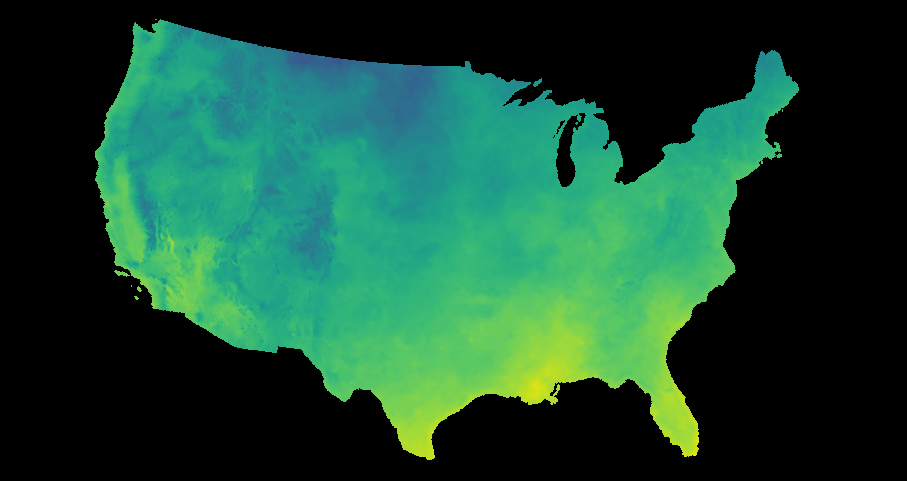

In [5]:
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)

fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(projection=map_proj))
ax.set_axis_off()
quadmesh = chunk[0].plot(
    ax=ax, add_colorbar=False, add_labels=False, transform=ccrs.PlateCarree()
)


def animate(i):
    a = chunk[i].data.ravel()
    a2 = numpy.ma.array(a, mask=np.isnan(a))
    quadmesh.set_array(a2)
    return [quadmesh]


anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(chunk), interval=120)
anim.save("anim.mp4", fps=15, extra_args=["-vcodec", "libx264"])

We can use IPython to display the video in the notebook.

In [6]:
from IPython.display import Video

Video("anim.mp4")

The video will only be embeded if you're running the notebook interactively. If you're just reading this example, you can see the output at

<video src="https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_video/pc-examples-gridmet-air-temperature.webm" controls>

### Next steps

* Learn more about [Reading Zarr data](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-zarr-data/)
* Learn more about [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/)